In [1]:
from mp_20_utils import load_all_data
datasets_pd, torch_datasets, site_to_ids, element_to_ids, spacegroup_to_ids, max_len = load_all_data()

In [2]:
import torch
from wyckoff_transformer import WyckoffTransformerModel
device='cpu'
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 4  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 4  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
n_space_groups = len(spacegroup_to_ids)
# Nope, not all SGs are present
# assert n_space_groups == 230
model = WyckoffTransformerModel(
    n_space_groups = n_space_groups,
    n_sites = len(site_to_ids),
    n_elements = len(element_to_ids),
    d_space_groups = 16,
    d_sites = 64,
    d_species = 64,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout).to(device)
model.load_state_dict(torch.load('checkpoints/2024-03-04_22-21-57/best_model_params.pt'))
model.eval()

RuntimeError: Error(s) in loading state_dict for WyckoffTransformerModel:
	size mismatch for linear.weight: copying a param with shape torch.Size([181, 144]) from checkpoint, the shape in current model is torch.Size([182, 144]).
	size mismatch for linear.bias: copying a param with shape torch.Size([181]) from checkpoint, the shape in current model is torch.Size([182]).

In [ ]:
from torch import optim
from torch import nn

class CalibrateFromLogits(nn.Module):
    def __init__(
        self, lr:float=0.1, max_iter:int=100, device:str='cpu'):
        super().__init__()
        self.lr = lr
        self.max_iter = max_iter
        self.device = device
        self.temperature = nn.Parameter(torch.ones(1, device=device), requires_grad=True)
        self.optimizer = optim.LBFGS([self.temperature], lr=lr, max_iter=max_iter)
        self.criterion = nn.CrossEntropyLoss()
    
    def fit(self, logits, targets):
        """
        logits: (batch_size, n_classes)
        targets: (batch_size)
        """
        def calib_eval() -> float:
            self.optimizer.zero_grad()
            scaled_predictions = logits / self.temperature
            loss = self.criterion(scaled_predictions, targets)
            loss.backward()
            return loss
        self.optimizer.step(calib_eval)
        return self

In [ ]:
from wyckoff_transformer import get_batches
from tokenization import MASK_SITE
MASK_ID_TENSOR=torch.tensor(site_to_ids[MASK_SITE]).to(device)
scalers_element = []
scalers_site = []
for known_seq_len in range(1, max_len - 1):
    ((data_element, target_element), (data_site, target_site)) = get_batches(
        torch_datasets['val']["symmetry_sites"],
        torch_datasets['val']["symmetry_elements"],
        known_seq_len,
        MASK_ID_TENSOR)
    output_element = model(torch_datasets['val']["spacegroup_number"], **data_element,
                           padding_mask=torch_datasets['val']["padding_mask"][:, :known_seq_len])[0].detach()
    scalers_element.append(CalibrateFromLogits().fit(output_element[:, -1, :], target_element))
    output_site = model(torch_datasets['val']["spacegroup_number"], **data_site,
                        padding_mask=torch_datasets['val']["padding_mask"][:, :known_seq_len + 1])[1].detach()
    scalers_site.append(CalibrateFromLogits().fit(output_site[:, -1, :], target_site))

In [ ]:
space_groups = torch_datasets["test"]["spacegroup_number"]
sites = torch_datasets["test"]["symmetry_sites"][:, [0]]
elements = torch_datasets["test"]["symmetry_elements"][:, [0]]
from torch.nn.functional import softmax
for i in range(max_len - 2):
    probas_elements = softmax(model(space_groups, sites, elements, None)[0]/scalers_element[i].temperature, -1)
    next_elemenets = torch.multinomial(probas_elements[:, -1, :], 1)
    elements = torch.cat((elements, next_elemenets), 1)

    masked_sites = torch.cat([sites, MASK_ID_TENSOR.expand(sites.shape[0], 1)], dim=1)
    probas_sites = softmax(model(space_groups, masked_sites, elements, None)[1]/scalers_site[i].temperature, -1)
    next_sites = torch.multinomial(probas_sites[:, -1, :], 1)
    sites = torch.cat((sites, next_sites), 1)

In [ ]:
idx_to_element = {idx: element for element, idx in element_to_ids.items()}
idx_to_site = {idx: site for site, idx in site_to_ids.items()}
idx_to_spacegroup = {idx: spacegroup for spacegroup, idx in spacegroup_to_ids.items()}

In [ ]:
from pymatgen.core import DummySpecie
PAD_ID = site_to_ids["PAD"]
STOP_ID = site_to_ids["STOP"]
ELEMENT_PAD_ID = element_to_ids[DummySpecie()]
ELEMENT_STOP_ID = element_to_ids["STOP"]

In [ ]:
generated_structuers = []
for this_elements, this_sites, this_spacegroup in zip(elements, sites, space_groups):
    sites_str = []
    elements_str = []
    for i in range(len(this_sites)):
      if this_sites[i] in (PAD_ID, STOP_ID) or this_elements[i] in (ELEMENT_PAD_ID, ELEMENT_STOP_ID):
        break
      sites_str.append(idx_to_site[int(this_sites[i])])
      elements_str.append(idx_to_element[int(this_elements[i])])
    generated_structuers.append({
        "spacegroup": int(idx_to_spacegroup[int(this_spacegroup)]),
        "sites": sites_str,
        "elements": elements_str
    })

In [ ]:
import pandas as pd
all_datasets = pd.concat(datasets_pd.values())

In [ ]:
from collections import defaultdict
from pyxtal.symmetry import Group
wp_index = defaultdict(lambda: defaultdict(set))
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()
        wp_index[group_number][wp.site_symm].add((wp.multiplicity, wp.letter, wp.get_dof()))

In [ ]:
from collections import Counter
from copy import deepcopy
import logging
from random import choice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
valid_structures = []
for example in generated_structuers:
    # element: composition, site
    pyxtal_args = defaultdict(lambda: [0, []])
    available_sites = deepcopy(wp_index[example["spacegroup"]])
    try:
        for site, element in zip(example['sites'], example['elements']):
            if len(available_sites[site]) == 0:
                raise KeyError(f"Can't place site {site} in spacegroup {example['spacegroup']}")
            choosen_wyckoff_position = choice(list(available_sites[site]))
            pyxtal_args[element][0] += choosen_wyckoff_position[0]
            pyxtal_args[element][1].append(str(choosen_wyckoff_position[0])+choosen_wyckoff_position[1])
            if choosen_wyckoff_position[2] == 0: # The position is special
                available_sites[site].remove(choosen_wyckoff_position)
        valid_structures.append({
            "spacegroup": example['spacegroup'],
            "sites": [x[1] for x in pyxtal_args.values()],
            "elements": list(map(str, pyxtal_args.keys())),
            "composition": [x[0] for x in pyxtal_args.values()]
        })
    except KeyError as e:
        logging.warning(e)
        logging.warning(example)
        logging.warning(pyxtal_args)

In [12]:
print(len(valid_structures), len(generated_structuers))

8220 9046


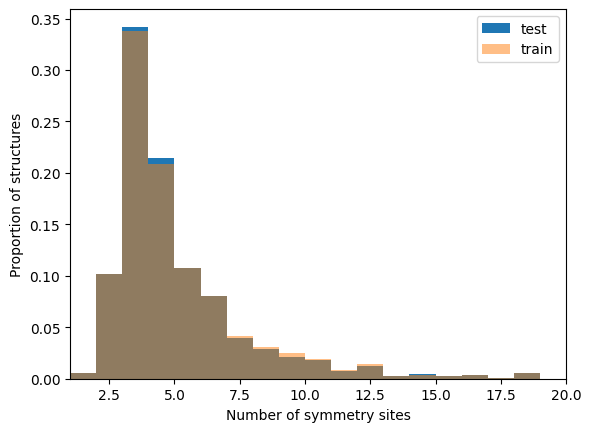

In [13]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(1, max_len - 1)
ax.hist(datasets_pd['test'].symmetry_sites.map(len), label="test", density=True, bins=x)
ax.hist(datasets_pd['train'].symmetry_sites.map(len), label="train", density=True, alpha=0.5, bins=x)
#ax.hist(list(map(lambda s: len(s["elements"]), valid_structures)), label="generated", density=True, alpha=0.5, bins=x)
ax.set_xlabel("Number of symmetry sites")
ax.set_ylabel("Proportion of structures")
ax.legend()
ax.set_xlim(1, max_len - 1);

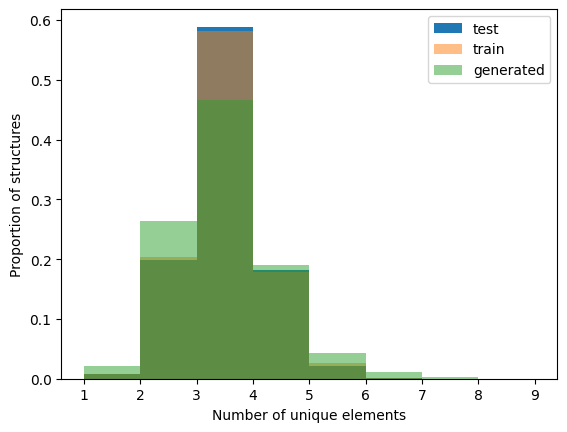

In [14]:
def count_elements(record):
    return len(set(record["elements"]))
def count_elements_pd(record):
    return len(set(record.structure.elements))
fig, ax = plt.subplots()
bins = np.arange(1, 10)
ax.hist(datasets_pd['test'].apply(count_elements_pd, axis=1), label="test", density=True, bins=bins)
ax.hist(datasets_pd['train'].apply(count_elements_pd, axis=1), label="train", density=True, alpha=0.5, bins=bins)
ax.hist(list(map(count_elements, valid_structures)), label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Proportion of structures")
ax.legend();

In [15]:
valid_structures[4]

{'spacegroup': 8,
 'sites': [['2a', '2a', '2a'], ['2a', '2a', '2a', '2a', '2a', '2a']],
 'elements': ['Ho', 'Br'],
 'composition': [6, 12]}

In [16]:
import pyxtal
example = valid_structures[4]
generator = pyxtal.pyxtal()
generator.from_random(3, group=example["spacegroup"], species=example["elements"],
                      numIons=example["composition"], sites=example["sites"])

In [17]:
example

{'spacegroup': 8,
 'sites': [['2a', '2a', '2a'], ['2a', '2a', '2a', '2a', '2a', '2a']],
 'elements': ['Ho', 'Br'],
 'composition': [6, 12]}

In [18]:
ase_struct = generator.to_ase()
import ase.visualize
ase.visualize.view(ase_struct, viewer="ngl")

In [19]:
import json
#with open("generated.json", "w") as f:
    #json.dump(valid_structures, f)